In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - power_spectrum_2d_bar.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the 2D power spectrum of the Dehnen bar and see what happens.
'''

__author__ = "James Lane"

In [5]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier
import ast1501.df

In [6]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- See the `ast1501.fourier` module
- Bovy RC stuff https://github.com/jobovy/apogee-rc/tree/master/py
- Check Bovy paper http://iopscience.iop.org/article/10.1088/0004-637X/800/2/83/pdf
- Ginsburg FFT stuff https://github.com/keflavich/agpy/tree/master/AG_fft_tools

# Prepare

## Functions

In [28]:
def plot_grid(hist, vmin, vmax, extent, cmap):

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    radii = np.arange(4,15,1.0)
    for r in radii:
        orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
        ax.add_artist(orbit_circle)
    ###r
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

## Load data
Load the simulated bar data.

In [11]:
filename = '../../scripts/generate_bar_df/2019-02-24/data.npy'
data = np.load(filename).astype(float)

## Fix grid parameters
Decide on the spacing parameters for the velocity grid

In [101]:
# Bin centers from the data
x_bin_cents = np.sort( np.unique(data[:,2]) )
y_bin_cents = np.sort( np.unique(data[:,3]) )

# Think we know the delta. This will let us know if we don't
dx = 0.75
dy = 0.75
for _dx in np.diff(x_bin_cents):
    assert dx == _dx
#for
for _dy in np.diff(y_bin_cents):
    assert dy == _dy
#for

# X and Y range in kpc
x_hi = np.max(x_bin_cents) + dx/2
x_lo = np.min(x_bin_cents) - dx/2
y_hi = np.max(y_bin_cents) + dy/2
y_lo = np.min(y_bin_cents) - dy/2

n_xbins = len(x_bin_cents)
n_ybins = len(y_bin_cents)

In [102]:
# Bush league re-gridding
grid_x, grid_y = np.meshgrid( x_bin_cents, y_bin_cents )
grid_x = grid_x.T
grid_y = grid_y.T

grid_vr = np.zeros_like( grid_x )
grid_vt = np.zeros_like( grid_x )
grid_svr = np.zeros_like( grid_x )
grid_svt = np.zeros_like( grid_x )

for i in range( len( x_bin_cents ) ):
    for j in range( len( y_bin_cents ) ):
            
        ind = np.where( (x_bin_cents[i] == data[:,2] ) &
                        (y_bin_cents[j] == data[:,3] ) )[0][0]
           
        grid_vr[i,j] = data[ind,4]
        grid_svr[i,j] = data[ind,5]
        grid_vt[i,j] = data[ind,6]
        grid_svt[i,j] = data[ind,7]
        
        # Make sure we have the correct spatial positions
        assert grid_x[i,j] == x_bin_cents[i]
        assert grid_y[i,j] == y_bin_cents[j]
    ###j
###i

# Plot

## Prepare

In [103]:
### Prepare for plotting

# Sun
x_sun = 8.125

## Plot the velocity maps
Radial velocities

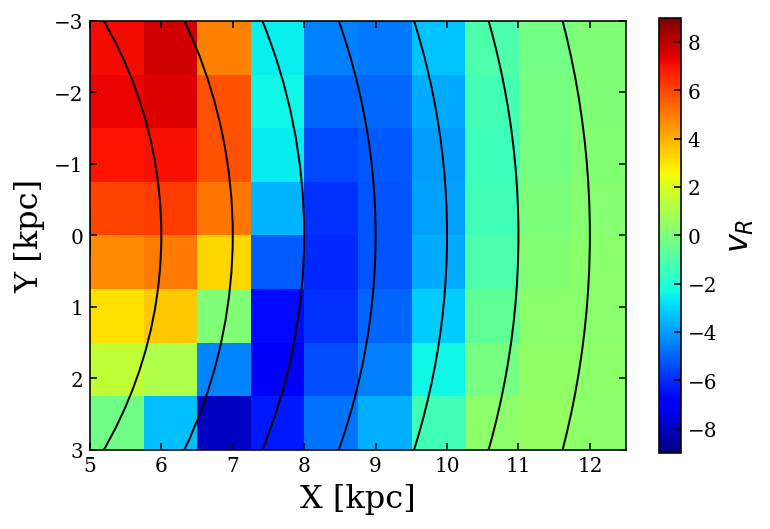

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)

img = ax.imshow( grid_vr.T, extent=(x_lo,x_hi,y_hi,y_lo), cmap='jet', 
                    vmin=-9, vmax=9)

cbar = plt.colorbar(img)

# Plot at the radii
radii = np.arange(4,15,1.0)
for r in radii:
    orbit_circle = plt.Circle((0, 0), r, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
###r

# Labels
ax.set_xlabel('X [kpc]', fontsize=16)
ax.set_ylabel('Y [kpc]', fontsize=16)
cbar.set_label(r'$v_{R}$', fontsize=16)

plt.show()
pass;

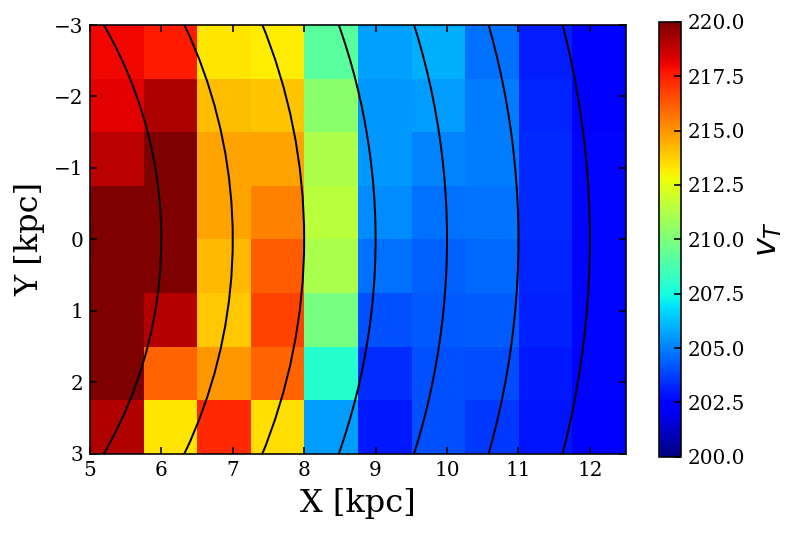

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)

img = ax.imshow( grid_vt.T, extent=(x_lo,x_hi,y_hi,y_lo), cmap='jet', 
                    vmin=200, vmax=220)

cbar = plt.colorbar(img)

# Plot at the radii
radii = np.arange(4,15,1.0)
for r in radii:
    orbit_circle = plt.Circle((0, 0), r, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
###r

# Labels
ax.set_xlabel('X [kpc]', fontsize=16)
ax.set_ylabel('Y [kpc]', fontsize=16)
cbar.set_label(r'$v_{T}$', fontsize=16)

plt.show()
pass;

In [108]:
# ind = 25
# print( 'X: '+str(data[ind,2])+' kpc' )
# print( 'Y: '+str(data[ind,3])+' kpc' )
# print( 'vR: '+str(data[ind,4])+' kpc' )
# print( 'vT: '+str(data[ind,6])+' kpc' )

## Make the power spectrum

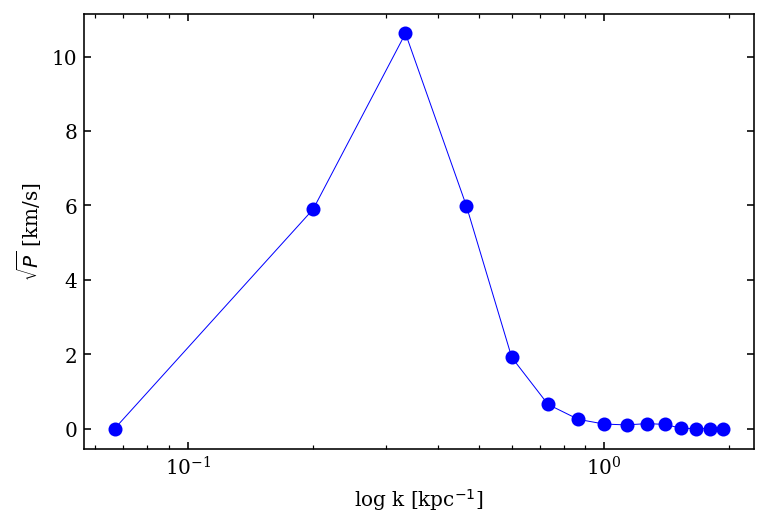

In [128]:
k_vR, pk_vR, _ = ast1501.fourier.psd1d(grid_vr,dx,binsize=1.0)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( k_vR, 4*np.pi*pk_vR, color='Blue', linewidth=0.5, marker='o' )

ax.set_xscale('log')

ax.set_xlabel(r'log k [kpc$^{-1}$]')
ax.set_ylabel(r'$\sqrt{P}$ [km/s]')

plt.show()
plt.close('all')

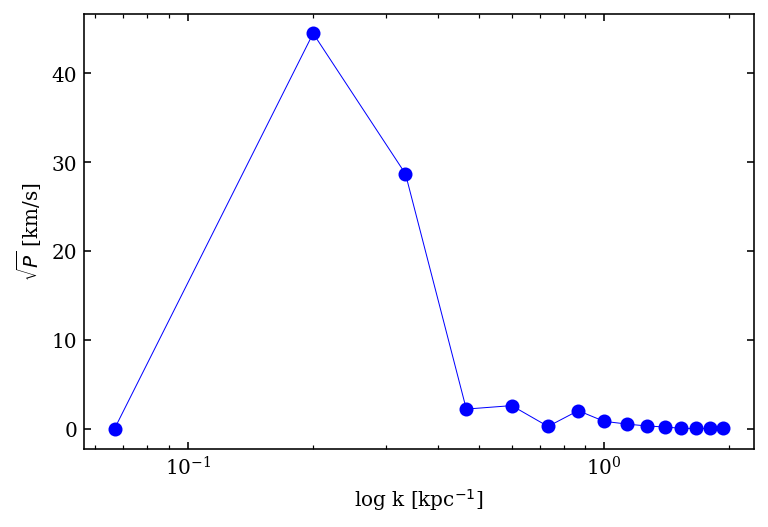

In [129]:
k_vT, pk_vT, _ = ast1501.fourier.psd1d(grid_vt,dx,binsize=1.0)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( k_vT, 4*np.pi*pk_vT, color='Blue', linewidth=0.5, marker='o' )

ax.set_xscale('log')

ax.set_xlabel(r'log k [kpc$^{-1}$]')
ax.set_ylabel(r'$\sqrt{P}$ [km/s]')

plt.show()
plt.close('all')